best error: 9.91e+03


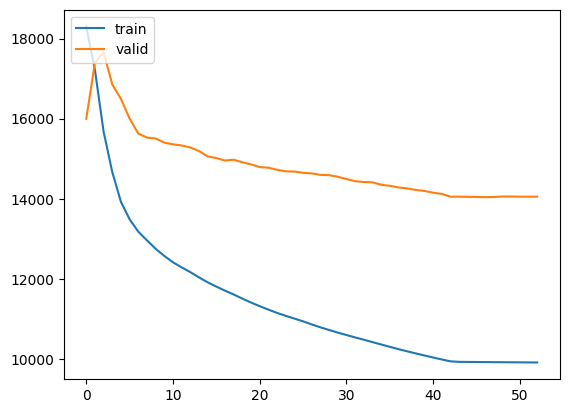

In [76]:
from data_reader import read_interaction_matrix
from mf import matrix_factorization, error, error_pq
from matplotlib import pyplot as plt
import numpy as np


def split_train_valid(R, th=0.8):
    i, j = R.nonzero()
    n = i.shape[0]
    n_train = int(th * n)
    
    s = np.random.default_rng(1234).choice(n, n_train, False)

    M = np.zeros_like(R)
    M[(i[s], j[s])] = 1

    return M, R - M


def infer(q, p, th=0.2):
    U, I = q.shape[0], p.shape[0]
    M = np.zeros((U, I))
    S = q @ p.T
    S -= np.mean(S)
    S /= max(S.min(), S.max())
    M[S>th] = 1
    return M


def get_errors(logs):
    errors = [log[0] for log in logs]
    return errors


R = read_interaction_matrix()

R, RCV = split_train_valid(R)

q, p, err, logs = matrix_factorization(
    R, lr=(2e-2, 2e-3), n_epochs=210, sample_s=0.002, batch_sample_s=0.05
    )
errors = get_errors(logs)

print(f'best error: {err:.2e}')
plt.plot(errors, label='train')

def get_qps(logs):
    return [(q,p) for (_, q,p) in logs]

cv_errors = [error_pq(RCV, infer(*qp), *qp, reg=0.001) for qp in get_qps(logs)]
plt.plot(4*np.array(cv_errors), label='valid')
plt.legend(loc='upper left')
plt.show()

In [65]:
S = infer(q, p)
# a = list(zip(*RCV.nonzero()))
# b = list(zip(*S.nonzero()))
found = np.array([x in a for x in b]).sum()
print(f'S {S.nonzero()[0].shape}, RCV {RCV.nonzero()[0].shape}')
print(f'recall {found/len(a)*100:.2f} accuracy {found/len(b):.2f}')

S (59904,), RCV (4608,)
recall 20.57 accuracy 0.03


In [58]:
S.nonzero()[0], RCV.nonzero()[0]

(array([   0,    0,    0, ..., 1339, 1339, 1339]),
 array([   0,    0,    0, ..., 1338, 1339, 1339]))

In [67]:
import numpy as np

# S = (q @ p.T)
S = infer(q, p, 0.2)

def frmt(f):
    i = 5
    i += 1 if f < 0 else 0
    return str(f)[:i]

def describe(M, name=None):
    print((f'{name}\t' if name else '') + f'mean: {frmt(M.mean())}, min: {frmt(M.min())}, max: {frmt(M.max())}')

describe(RCV, 'RCV stat')
describe(S, 'S stat')
describe(S[RCV.nonzero()], 'Positives stat')
describe((S - S*RCV), 'Others stat')

frmt(S.sum()), frmt(RCV.sum()), S[RCV.nonzero()]

RCV stat	mean: 0.004, min: 0.0, max: 1.0
S stat	mean: 0.060, min: 0.0, max: 1.0
Positives stat	mean: 0.313, min: 0.0, max: 1.0
Others stat	mean: 0.059, min: 0.0, max: 1.0


('59904', '4608.', array([1., 0., 0., ..., 0., 1., 1.]))

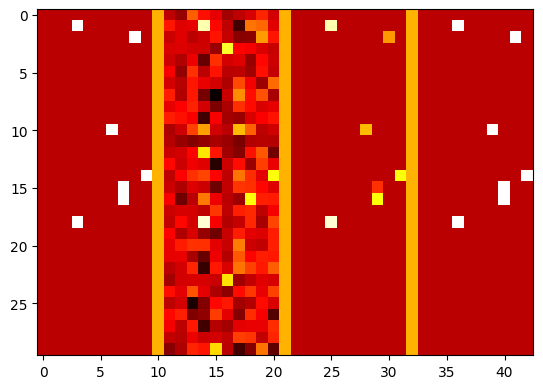

In [68]:
from mf import heatmap
import numpy as np

S = q @ p.T

FP = np.zeros_like(S)
FP[S > S.max() * 0.5] = -1
FP[R.nonzero()] = 1

P = S * R
Z = S - (S * R)

D = np.zeros((P.shape[0], 1))
D[:,0] = 0.5

t = tuple(M[60:90, 0:10] for M in (R, D, S, D, P, D, FP))
V = np.concatenate(t, axis=1)
heatmap(V)